In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
signal_trees = TreeIter(list(map(Tree,fc.eightb.accstudies_no_pu.signal_list)))

# signal_trees.extend(kwargs=lambda tree : dict(n_ext_jet=tree.n_jet-tree.nfound_presel))
# signal_trees.extend(kwargs=eightb.reco_all)
# signal_trees.extend(kwargs=eightb.reco_res_all)

In [3]:
def get_point(label):
    label = label.split('_')
    return str((int(label[1]),int(label[3])))
signal_points = list(map(get_point,signal_trees.sample))

In [4]:
dout = "gen_studies/quarks/"

tree = signal_trees[-2]

In [5]:
ylist = [
    f'gen_{y}'
    for y in ('Y1','Y2')
]

higgslist = [
    f'gen_{h}{y}'
    for y in ('Y1','Y2')
    for h in ('H1','H2')
]


quarklist = [
    f'gen_{h}{y}_{b}'
    for y in ('Y1','Y2')
    for h in ('H1','H2')
    for b in ('b1','b2')
]

In [6]:
def make_quark_variables(tree):
    quarks = ak.zip({
        var: ak.concatenate([tree[f'{quark}_{var}'][:, None]
                            for quark in quarklist], axis=-1)
        for var in ('pt', 'eta', 'phi', 'm')
    })
    quark_quark_dr = calc_dr(
        quarks.eta[:, :, None], quarks.phi[:, :, None], quarks.eta[:, None], quarks.phi[:, None])
    quark_min_quark_dr = ak.argmin(quark_quark_dr[quark_quark_dr != 0], axis=-1, keepdims=True)
    quark_min_quark_dr_id = ak.local_index(quark_quark_dr,axis=-1)[quark_quark_dr != 0][quark_min_quark_dr]
    quark_min_quark_dr = quark_quark_dr[quark_min_quark_dr_id][:,:,0]
    quark_min_quark_dr_id = quark_min_quark_dr_id[:,:,0]
    quark_n_quark_dr4 = ak.sum(
        quark_quark_dr[quark_quark_dr != 0] < 0.4, axis=-1)
    genjets = ak.zip({
        var: ak.concatenate(
            [tree[f'{quark}_genjet_{var}'][:, None] for quark in quarklist], axis=-1)
        for var in ('pt', 'eta', 'phi', 'm')
    })
    quark_genjet_dr = calc_dr(
        quarks.eta[:, :, None], quarks.phi[:, :, None], genjets.eta[:, None], genjets.phi[:, None])
    quark_min_genjet_dr = ak.min(quark_genjet_dr, axis=-1)
    quark_n_genjet_dr4 = ak.sum(quark_genjet_dr < 0.4, axis=-1)
    
    quarks_matched = 1*(genjets.pt > 0)
    
    sibMap = {0:1,2:3,4:5,6:7}
    sibMap.update({v:k for k,v in sibMap.items()})
    cos1Map = {0:[2,3],1:[2,3],2:[0,1],3:[0,1],4:[6,7],5:[6,7],6:[4,5],7:[4,5]}
    cos2Map = {0:[4,5,6,7],1:[4,5,6,7],2:[4,5,6,7],3:[4,5,6,7],4:[0,1,2,3],5:[0,1,2,3],6:[0,1,2,3],7:[0,1,2,3]}

    return dict(
        **{
            f'{quark}_sib_quark_dr': quark_quark_dr[:, i, sibMap[i]]
            for i, quark in enumerate(quarklist)
        },
        **{
            f'{quark}_min_cos1_quark_dr': ak.min(quark_quark_dr[:, i, cos1Map[i]],axis=-1)
            for i, quark in enumerate(quarklist)
        },
        **{
            f'{quark}_min_cos2_quark_dr': ak.min(quark_quark_dr[:, i, cos2Map[i]],axis=-1)
            for i, quark in enumerate(quarklist)
        },
        **{
            f'{quark}_min_quark_dr': quark_min_quark_dr[:, i]
            for i, quark in enumerate(quarklist)
        },
        **{
            f'{quark}_min_quark_dr_id': quark_min_quark_dr_id[:, i]
            for i, quark in enumerate(quarklist)
        },
        **{
            f'{quark}_min_genjet_dr': quark_min_genjet_dr[:, i]
            for i, quark in enumerate(quarklist)
        },
        **{
            f'{quark}_n_genjet_dr4': quark_n_genjet_dr4[:, i]
            for i, quark in enumerate(quarklist)
        },
        **{
            f'{quark}_n_quark_dr4': quark_n_quark_dr4[:, i]
            for i, quark in enumerate(quarklist)
        },
        **{
            f'{quark}_matched': quarks_matched[:, i]
            for i, quark in enumerate(quarklist)
        },
        **{
            f'gen_H1Y1_quark_dr': quark_quark_dr[:, 0, 1],
            f'gen_H2Y1_quark_dr': quark_quark_dr[:, 2, 3],
            f'gen_H1Y2_quark_dr': quark_quark_dr[:, 4, 5],
            f'gen_H2Y2_quark_dr': quark_quark_dr[:, 6, 7],
            f'n_unmatched_gen_quark':ak.sum(quarks_matched==0,axis=-1),
            f'n_unmatched_gen_quark_dr4':ak.sum((quarks_matched==0)&(quark_min_genjet_dr>0.4),axis=-1),
        }
    )


In [7]:
signal_trees.extend(kwargs=make_quark_variables)

signal_trees.extend(kwargs=lambda t : build_collection(t,'gen_H\dY\d_b\d','gen_quark'))

[None, None, None, None, None, None, None, None]

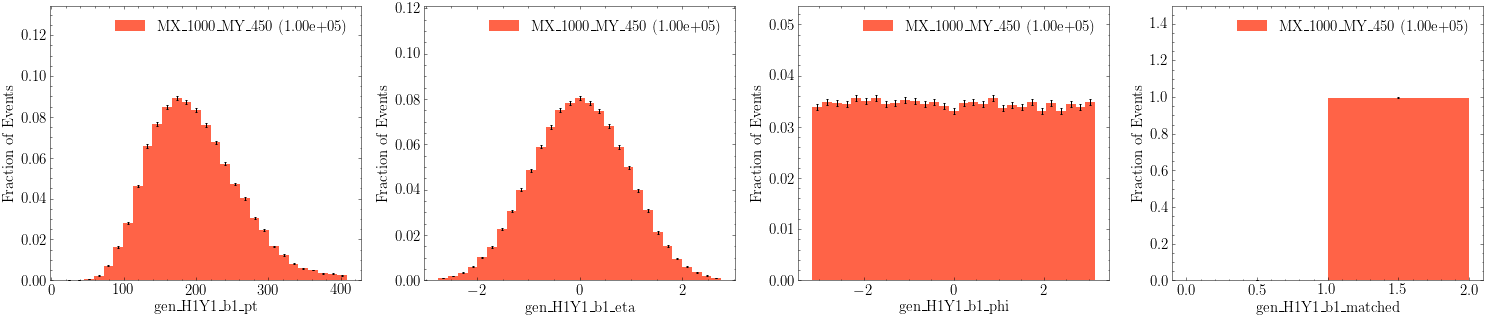

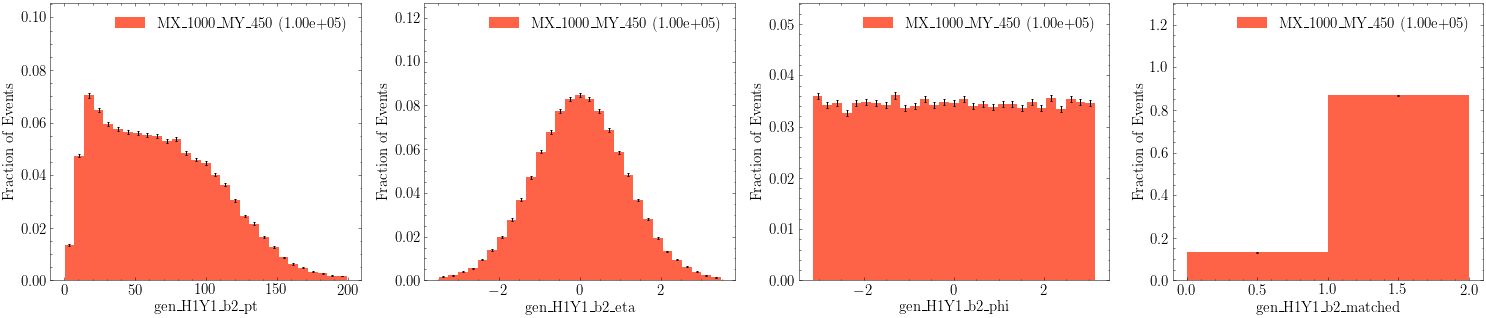

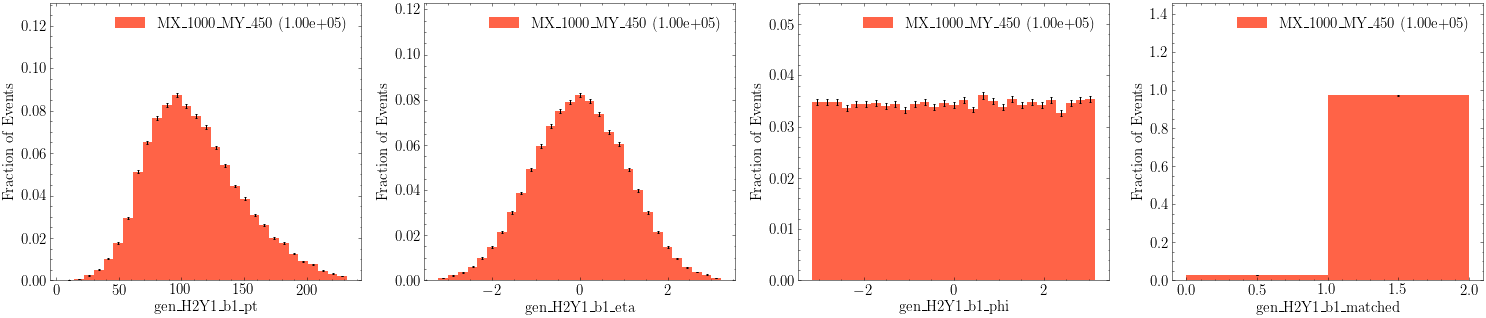

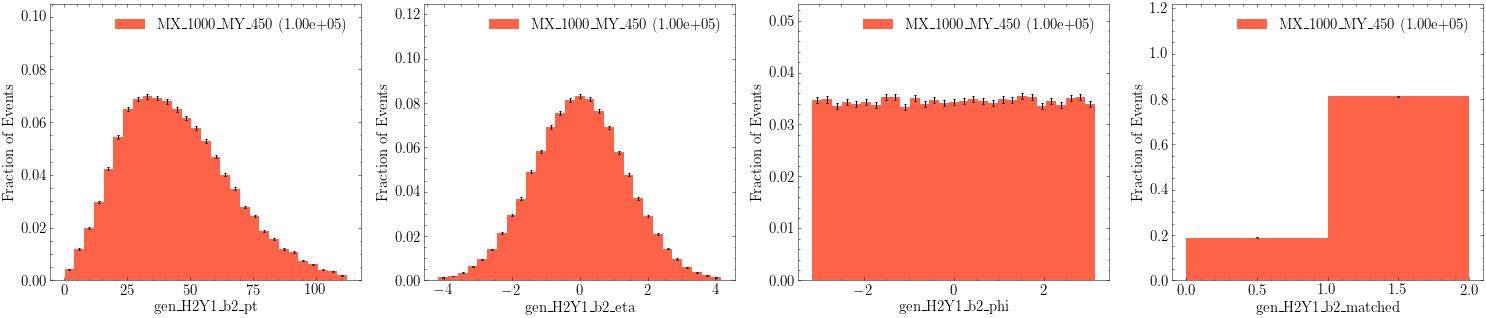

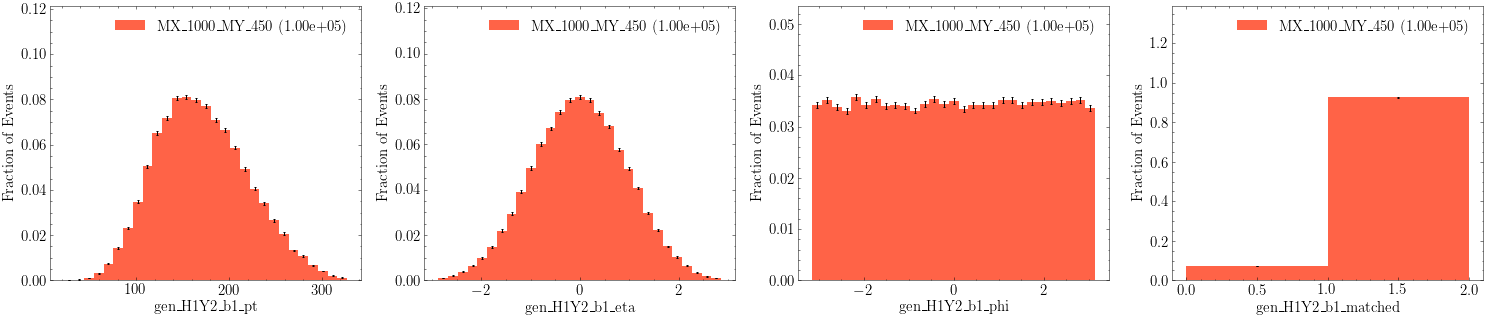

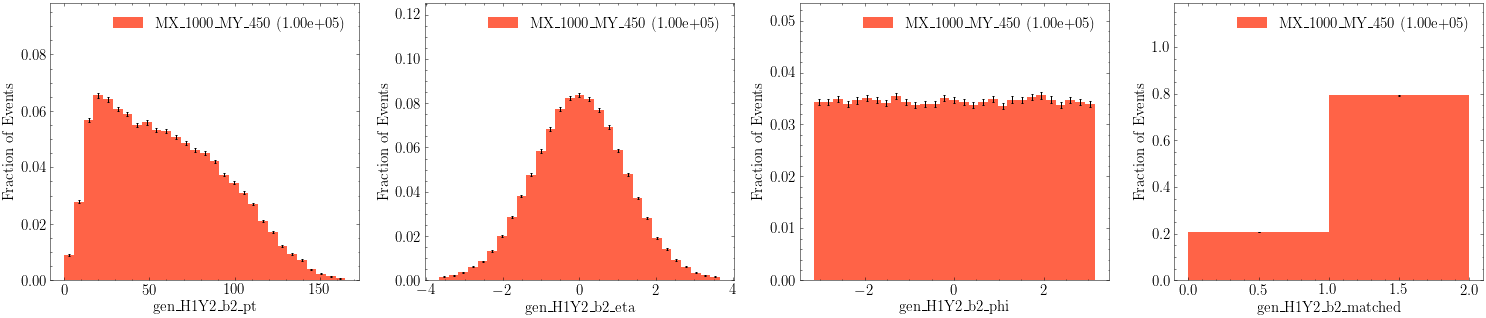

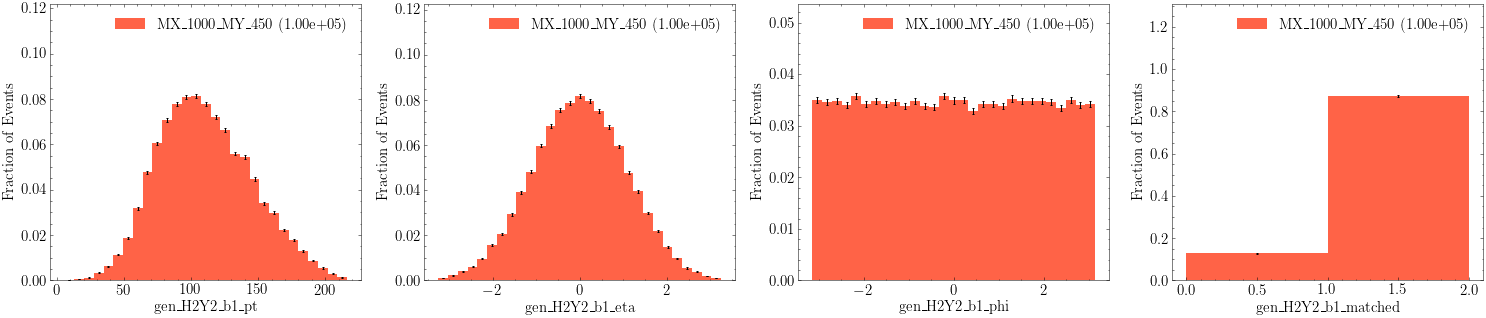

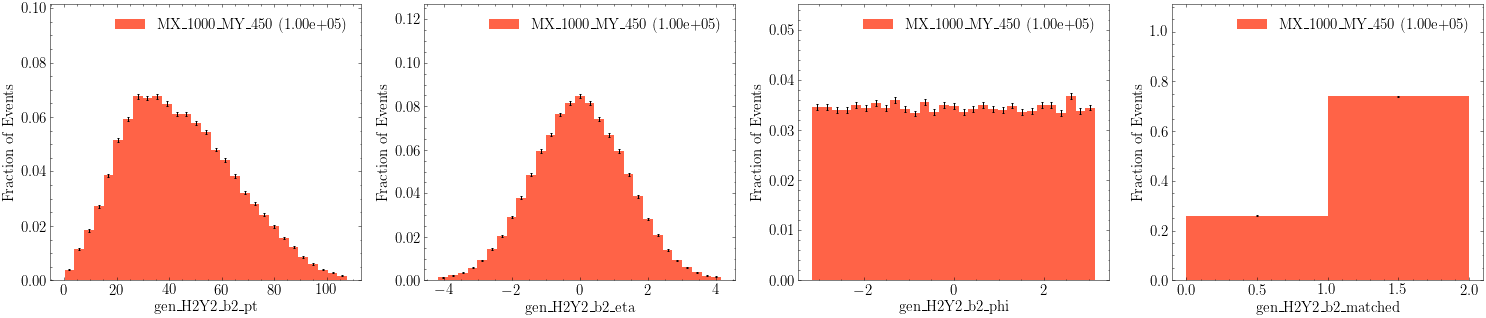

In [8]:
varlist = ['pt','eta','phi','matched']

for quark in quarklist:
    study.quick(
        [tree],
        varlist=[f'{quark}_{var}' for var in varlist],
        scale=False,
        density=1,
        dim=(-1,len(varlist)),
        saveas=f'{dout}/{quark}'
    )

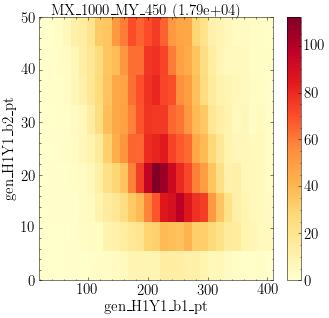

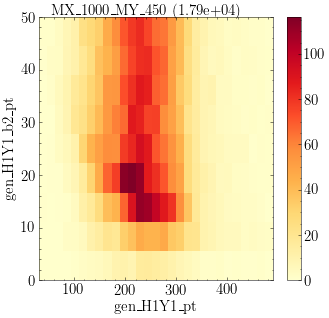

In [21]:
study.quick2d(
    [tree],
    varlist=['gen_H1Y1_b1_pt','gen_H1Y1_b2_pt'],
    binlist=[None,np.linspace(0,50,10)]
)

study.quick2d(
    [tree],
    varlist=['gen_H1Y1_pt','gen_H1Y1_b2_pt'],
    binlist=[None,np.linspace(0,50,10)]
)

Fraction Unmatched:              0.64
Fraction of Unmatched w/ dR>0.4: 0.47


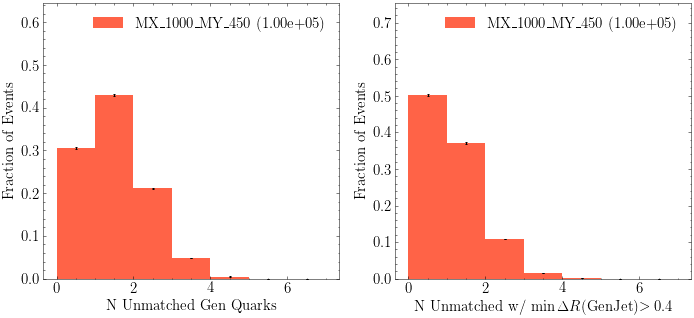

In [9]:
frac_unmatched = ak.sum(signal_trees[-1].n_unmatched_gen_quark>0)/1e5
frac_unmatched_dr4 = ak.sum(signal_trees[-1].n_unmatched_gen_quark_dr4>0)/1e5

print(f'Fraction Unmatched:              {frac_unmatched:0.2f}')
print(f'Fraction of Unmatched w/ dR>0.4: {frac_unmatched_dr4:0.2f}')

study.quick(
    [tree],
    varlist=['n_unmatched_gen_quark','n_unmatched_gen_quark_dr4'],
    scale=False,
    xlabels=['N Unmatched Gen Quarks','N Unmatched w/ $\min\Delta R$(GenJet)$>0.4$'],
    # s_colors=[None],
    density=1,
    saveas=f'{dout}/unmatched_quark_multiplicity'
)

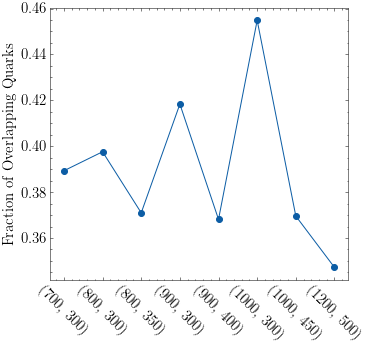

In [10]:
frac_overlap = [ ak.sum((tree[f'gen_quark_matched']==0)&(tree[f'gen_quark_min_genjet_dr']<0.4))/ak.sum(tree[f'gen_quark_matched']==0) for tree in signal_trees ]

fig,ax = graph_multi(signal_points,[frac_overlap],xlabel=signal_points,ylabel='Fraction of Overlapping Quarks')

study.save_fig(fig,'',f'{dout}/xy_point_frac_overlapping')

0.13


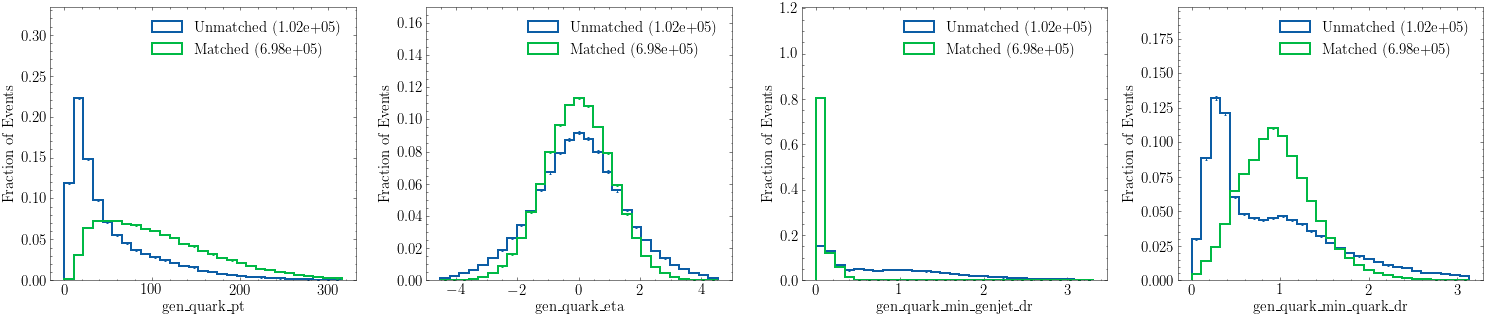

In [11]:
varlist = ['pt','eta','min_genjet_dr','min_quark_dr']

masks=[tree[f'gen_quark_matched']==0,tree[f'gen_quark_matched']==1]

print(f'{ak.sum(masks[0])/ak.count(tree.gen_quark_matched):0.2}')

study.quick(
    [tree,tree],
    masks=masks,
    varlist=[f'gen_quark_{var}' for var in varlist],
    scale=False,
    labels=['Unmatched','Matched'],
    s_colors=[None],
    density=1,
    dim=(-1,len(varlist)),
    saveas=f'{dout}/gen_quark_unmatched'
)

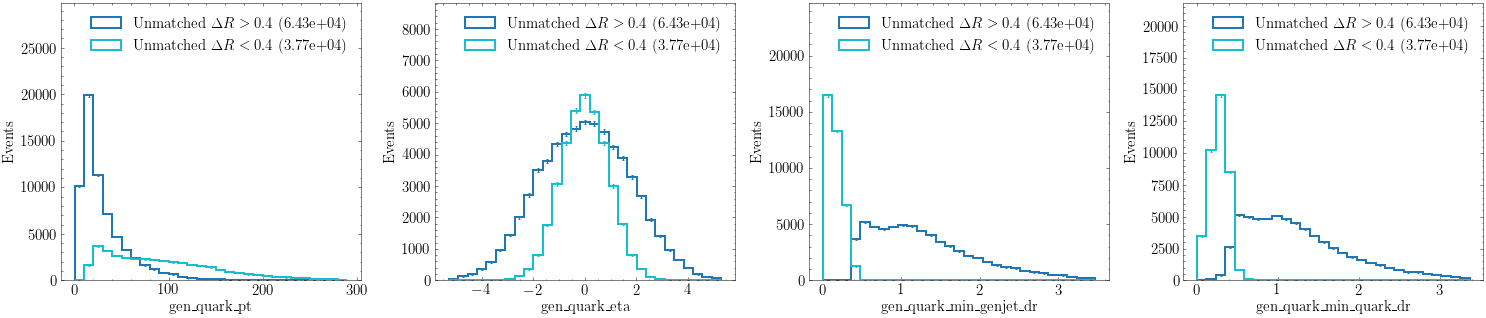

In [12]:
varlist = ['pt','eta','min_genjet_dr','min_quark_dr']

masks=[(tree[f'gen_quark_matched']==0)&(tree[f'gen_quark_min_genjet_dr']>0.4),(tree[f'gen_quark_matched']==0)&(tree[f'gen_quark_min_genjet_dr']<0.4)]
study.quick(
    [tree,tree],
    masks=masks,
    varlist=[f'gen_quark_{var}' for var in varlist],
    scale=False,
    labels=['Unmatched $\Delta R > 0.4$','Unmatched $\Delta R < 0.4$'],
    s_colors=['tab:blue','tab:cyan'],
    # density=1,
    dim=(-1,len(varlist)),
    saveas=f'{dout}/gen_quark_unmatched_drcut',
)

0.6304443812121628


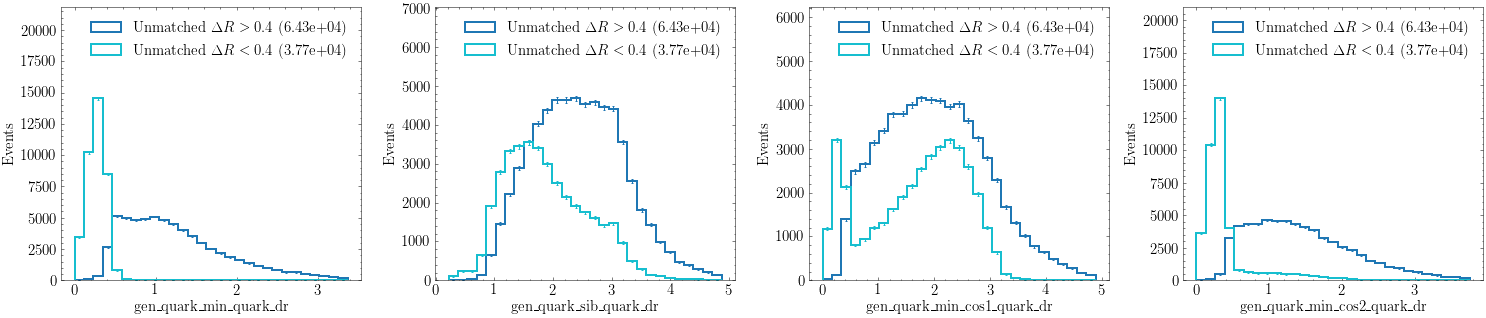

In [13]:
varlist = ['min_quark_dr','sib_quark_dr','min_cos1_quark_dr','min_cos2_quark_dr']

masks=[(tree[f'gen_quark_matched']==0)&(tree[f'gen_quark_min_genjet_dr']>0.4),(tree[f'gen_quark_matched']==0)&(tree[f'gen_quark_min_genjet_dr']<0.4)]

print(f'{ak.sum(masks[0])/ak.sum(tree.gen_quark_matched==0)}')
study.quick(
    [tree,tree],
    masks=masks,
    varlist=[f'gen_quark_{var}' for var in varlist],
    scale=False,
    labels=['Unmatched $\Delta R > 0.4$','Unmatched $\Delta R < 0.4$'],
    s_colors=['tab:blue','tab:cyan'],
    # density=1,
    dim=(-1,len(varlist)),
    saveas=f'{dout}/gen_quark_unmatched_family_dr',
)

MX_700_MY_300
0.6106971048018506


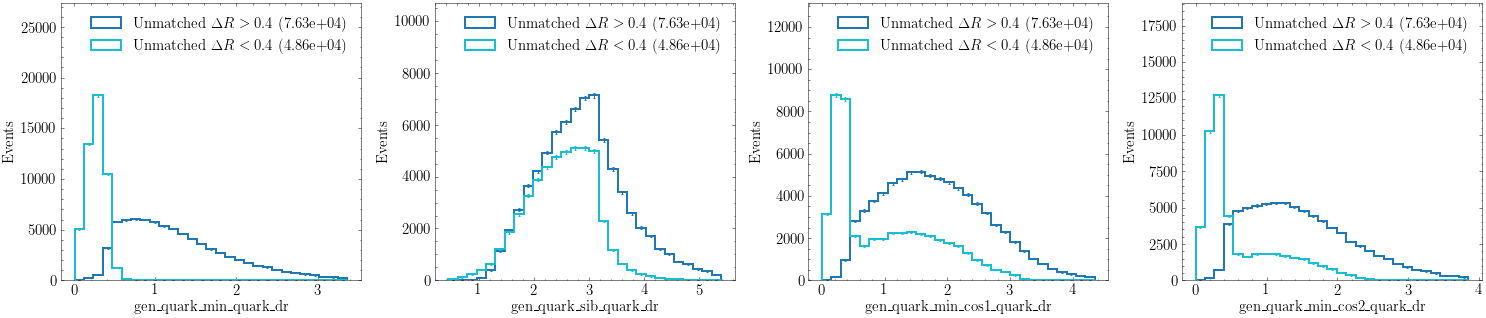

In [14]:
tree_1 = signal_trees[0]
print(tree_1.sample)

varlist = ['min_quark_dr','sib_quark_dr','min_cos1_quark_dr','min_cos2_quark_dr']

masks=[(tree_1[f'gen_quark_matched']==0)&(tree_1[f'gen_quark_min_genjet_dr']>0.4),(tree_1[f'gen_quark_matched']==0)&(tree_1[f'gen_quark_min_genjet_dr']<0.4)]

print(f'{ak.sum(masks[0])/ak.sum(tree_1.gen_quark_matched==0)}')
study.quick(
    [tree_1,tree_1],
    masks=masks,
    varlist=[f'gen_quark_{var}' for var in varlist],
    scale=False,
    labels=['Unmatched $\Delta R > 0.4$','Unmatched $\Delta R < 0.4$'],
    s_colors=['tab:blue','tab:cyan'],
    # density=1,
    dim=(-1,len(varlist)),
    # saveas=f'{dout}/gen_quark_unmatched_family_dr',
)

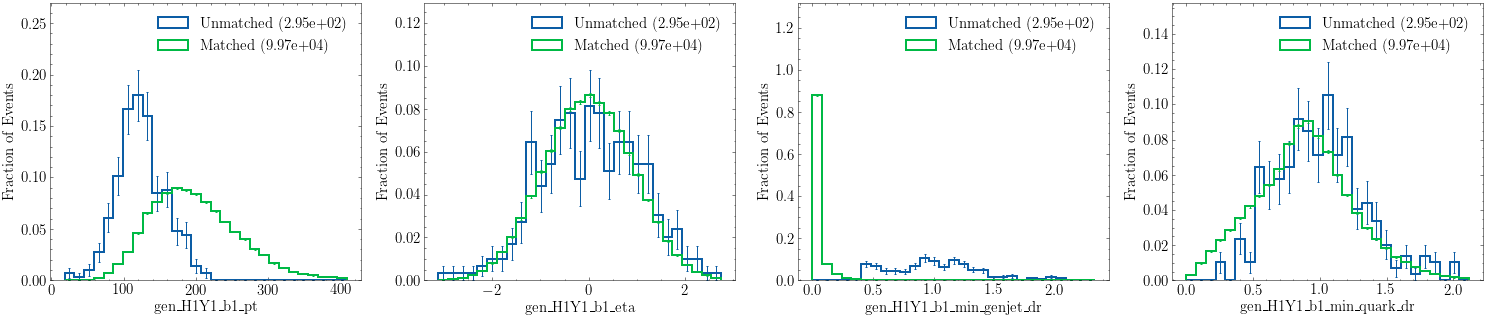

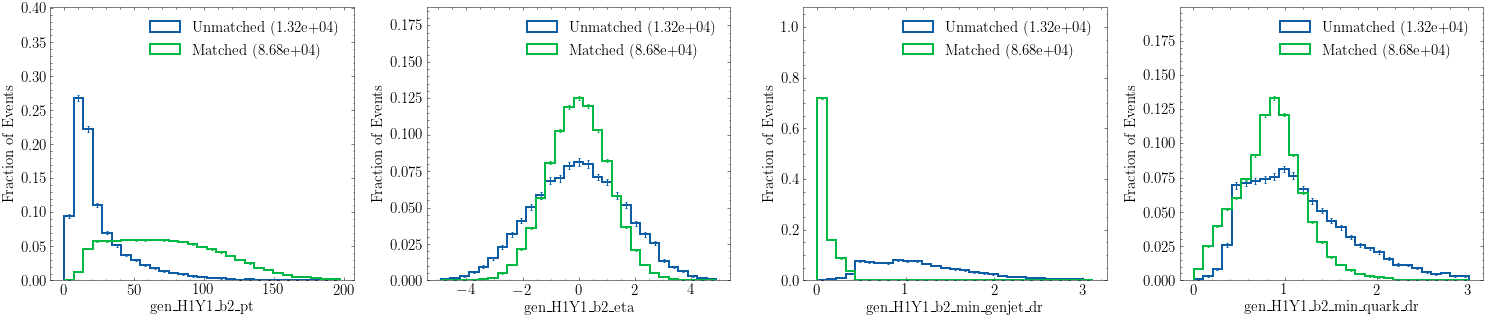

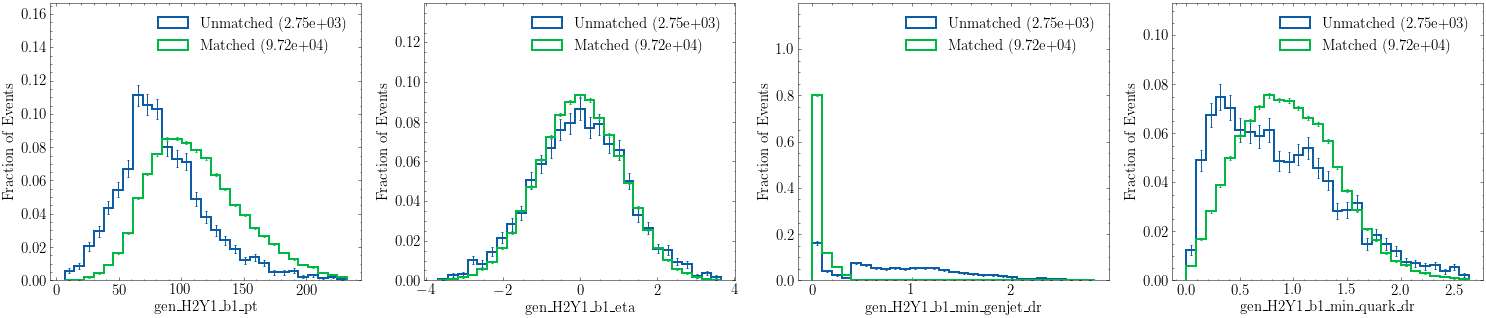

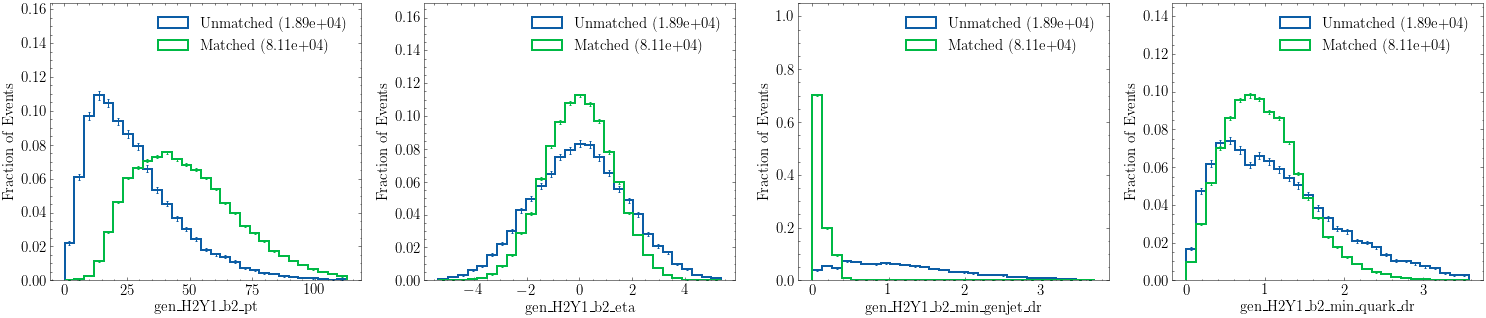

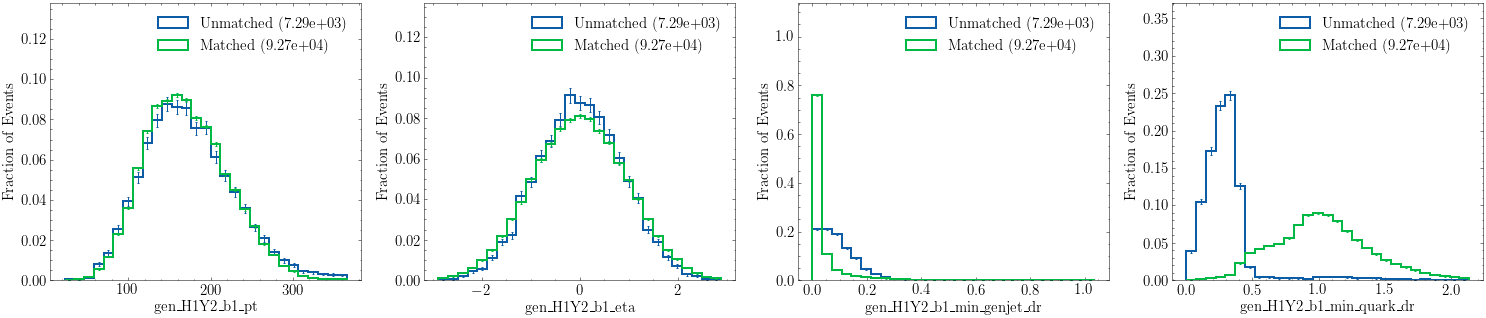

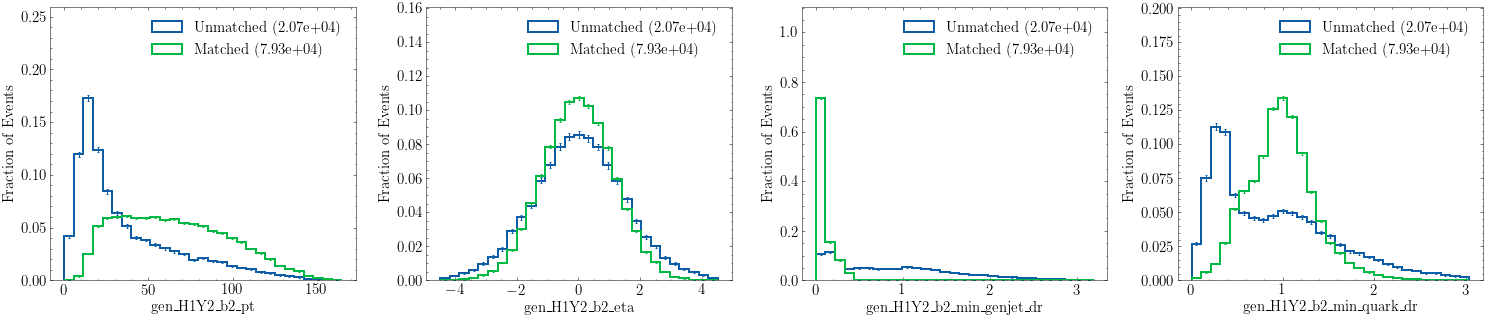

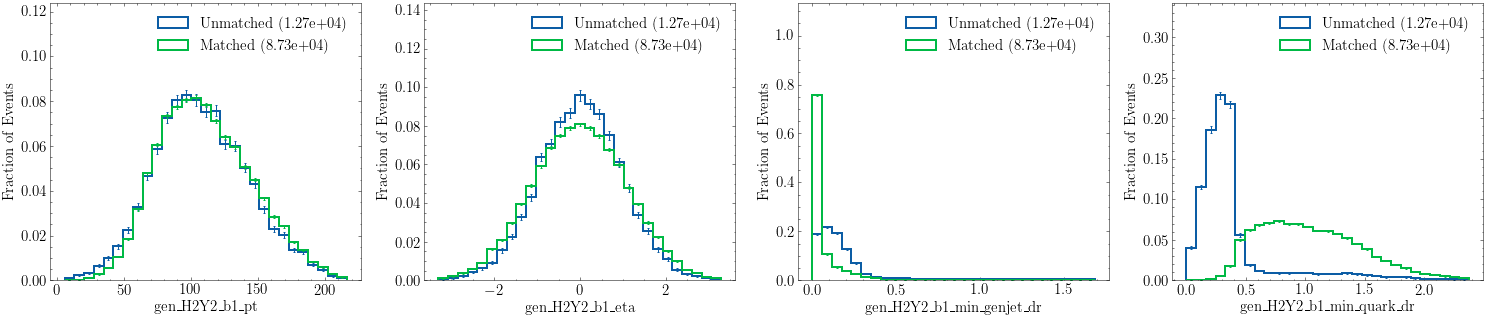

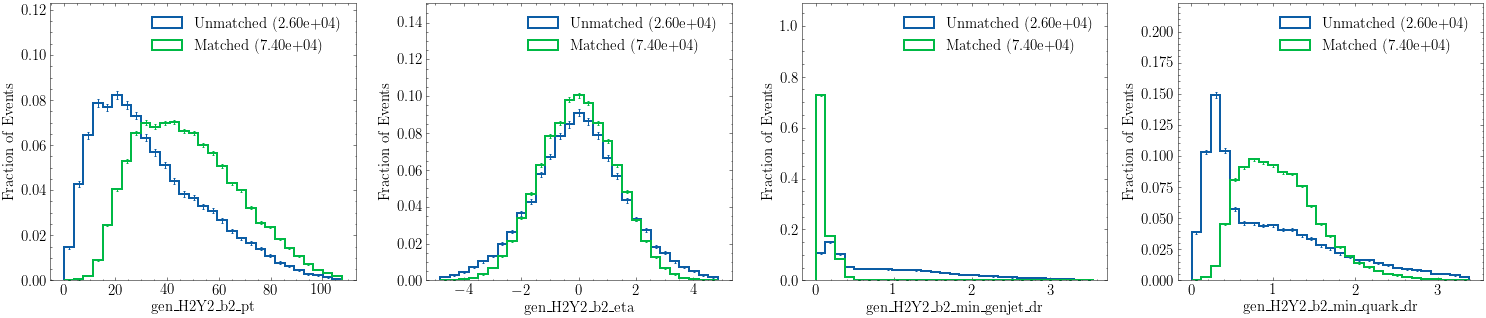

In [15]:
varlist = ['pt','eta','min_genjet_dr','min_quark_dr']

for quark in quarklist:
    masks=[tree[f'{quark}_matched']==0,tree[f'{quark}_matched']==1]
    study.quick(
        [tree,tree],
        masks=masks,
        varlist=[f'{quark}_{var}' for var in varlist],
        scale=False,
        labels=['Unmatched','Matched'],
        s_colors=[None],
        density=1,
        dim=(-1,len(varlist)),
        saveas=f'{dout}/{quark}_unmatched'
    )
    

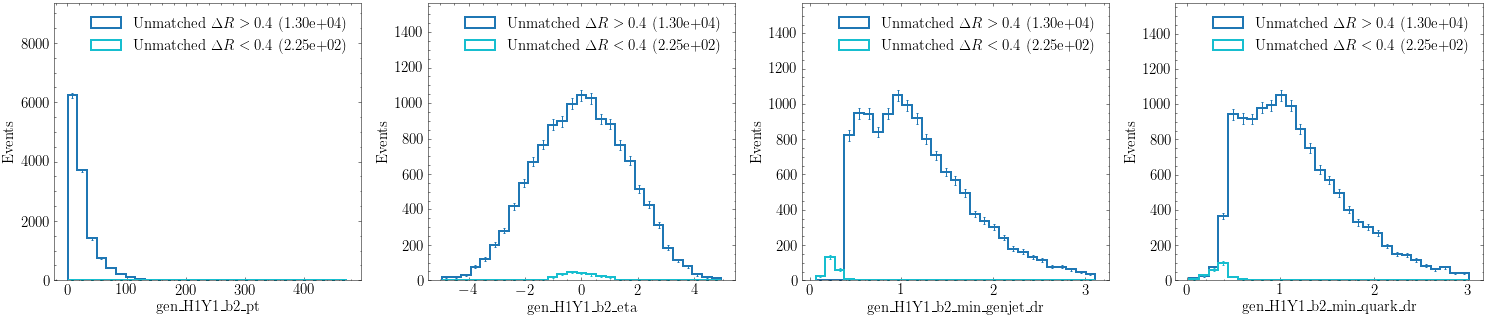

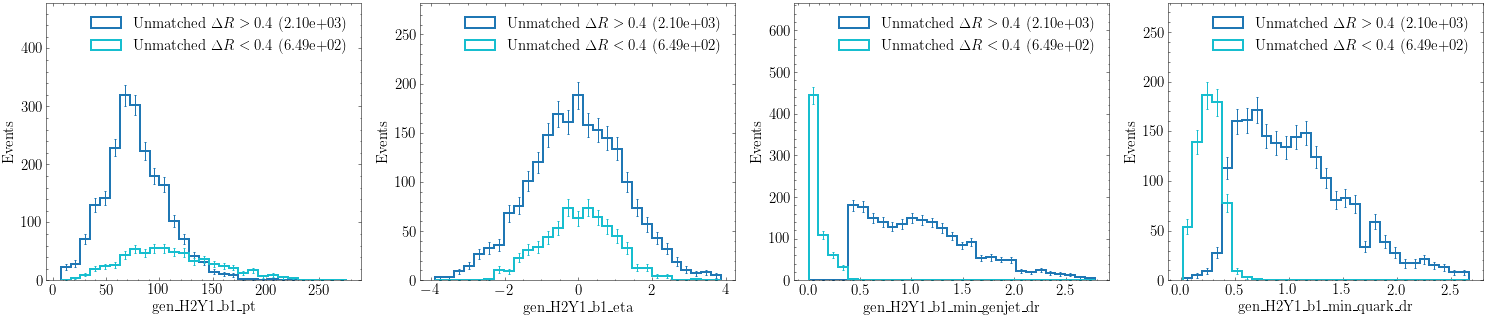

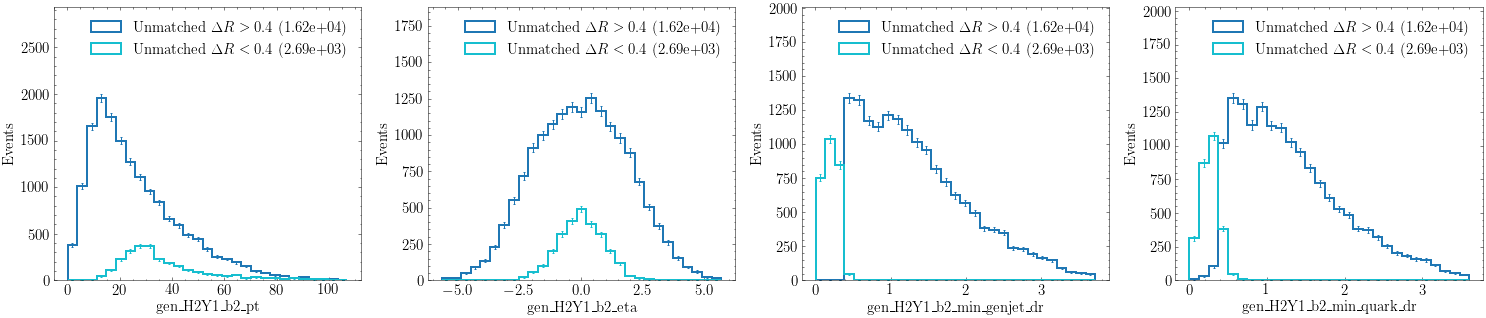

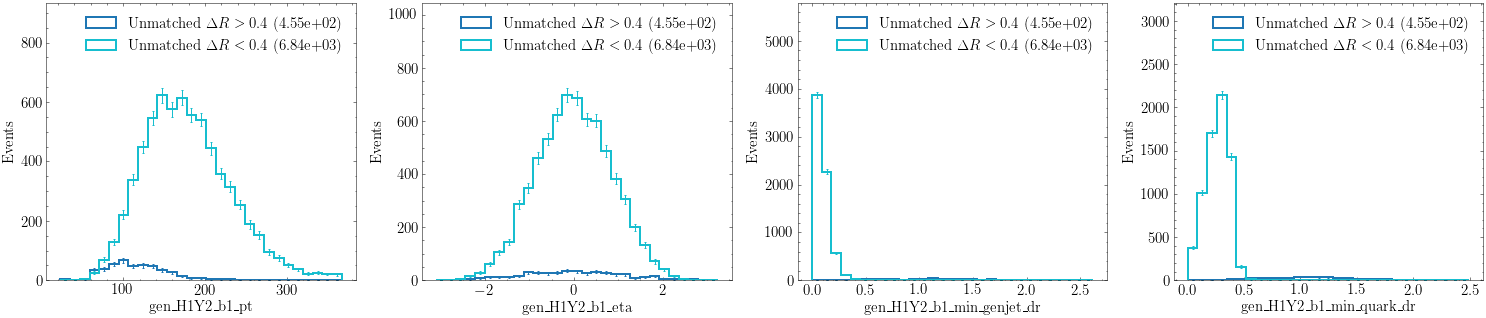

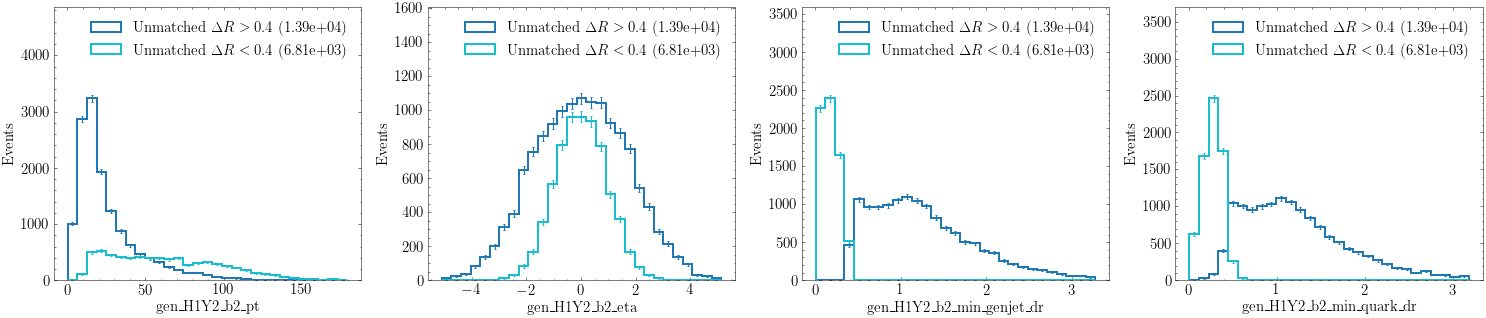

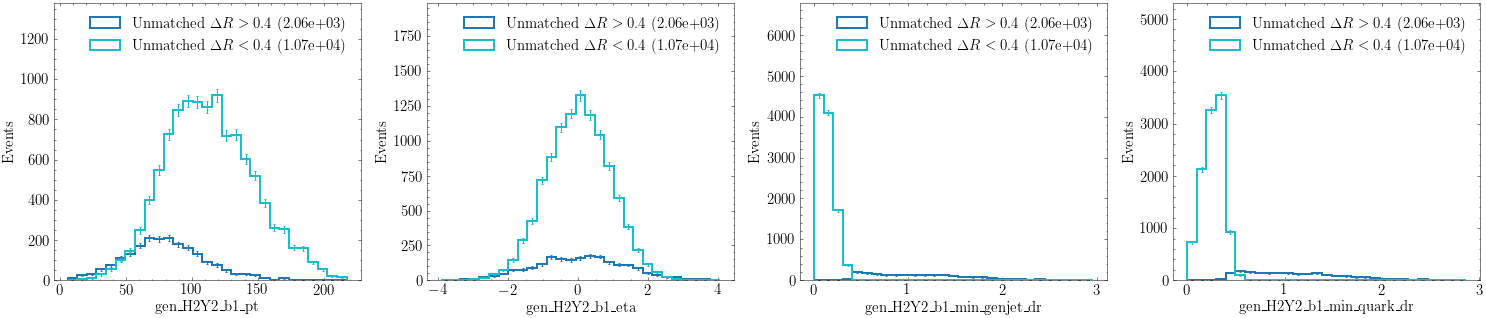

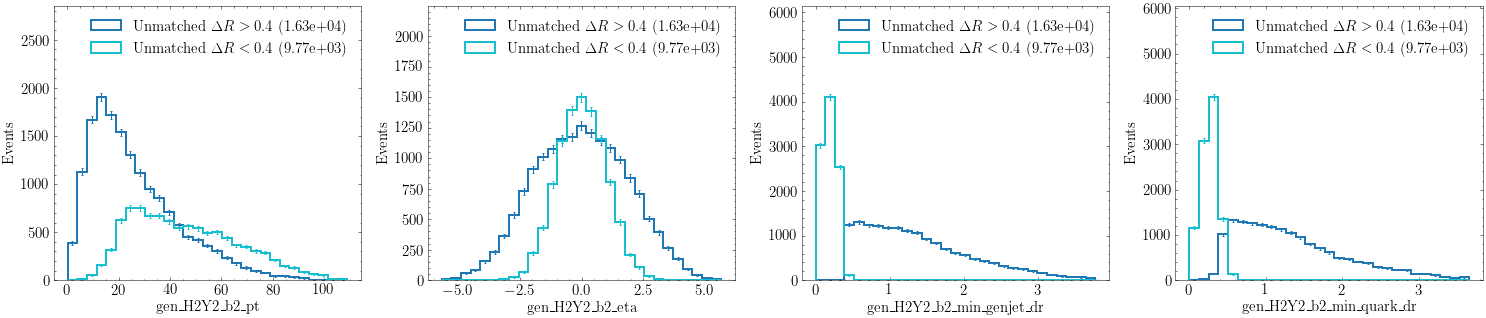

In [16]:
varlist = ['pt','eta','min_genjet_dr','min_quark_dr']


for quark in quarklist:
    masks=[(tree[f'{quark}_matched']==0)&(tree[f'{quark}_min_genjet_dr']>0.4),(tree[f'{quark}_matched']==0)&(tree[f'{quark}_min_genjet_dr']<0.4)]
    if any(map(lambda mask : ak.sum(mask)==0,masks)): continue
    study.quick(
        [tree,tree],
        masks=masks,
        varlist=[f'{quark}_{var}' for var in varlist],
        scale=False,
        labels=['Unmatched $\Delta R > 0.4$','Unmatched $\Delta R < 0.4$'],
        s_colors=['tab:blue','tab:cyan'],
        # density=1,
        dim=(-1,len(varlist)),
        saveas=f'{dout}/{quark}_unmatched_drcut',
    )